Model selection is the task of selecting a statistical model from a set of candidate models, given data. In the simplest cases, a pre-existing set of data is considered. Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice.

The data is available in Google BigQuery that can be downloaded from here. The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re


%matplotlib inline

In [2]:
df = pd.read_excel('database_clean.xlsx')[["Texto","Tipo de fuente"]]
df.columns=["post","tags"]
df = df[pd.notnull(df['tags'])]
df.head(10)



,post,tags
0,El rey de los animales Se reunieron los animal...,Cuentos
1,Domingo 7 Había una vez dos compadres jorobado...,Cuentos
2,Francisco El Hombre En los albores del siglo X...,Cuentos
3,Aminta Peláez- La leyenda de Wareke Hace muchí...,Cuentos
4,EL OASIS DE BELISSAMA ATLAUA pASeABA Con BeLis...,Cuentos
5,"El Tío LEóN, REY DE LA T IERRA Y DE LA SELVA ...",Cuentos
6,Azulay Vásquez - La historia de la ceiba que n...,Cuentos
7,El leñador Érase un joven leñador muy honrado....,Cuentos
8,Clara Helena Baquero - El tigre y el fuego Viv...,Cuentos
9,El compadre rico y el compadre pobre En una al...,Cuentos


In [3]:
df

,post,tags
0,El rey de los animales Se reunieron los animal...,Cuentos
1,Domingo 7 Había una vez dos compadres jorobado...,Cuentos
2,Francisco El Hombre En los albores del siglo X...,Cuentos
3,Aminta Peláez- La leyenda de Wareke Hace muchí...,Cuentos
4,EL OASIS DE BELISSAMA ATLAUA pASeABA Con BeLis...,Cuentos
...,...,...
3843,la justicia es la base de la democracia y el e...,Tweets
3844,la violencia y la delincuencia son una amenaza...,Tweets
3845,la educación es la base d. es importante que s...,Tweets
3846,la economía es un factor clave para el bienest...,Tweets


In [4]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

544868

We have over 10 million words in the data.

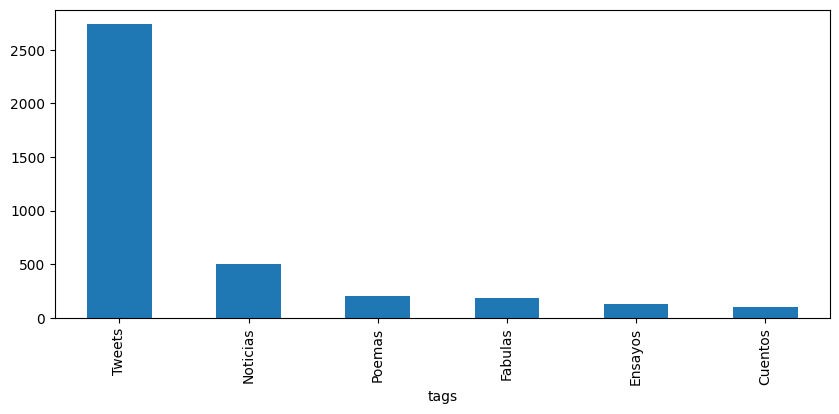

In [5]:
my_tags = ['Tweets','Noticias','Poemas','Fabulas','Ensayos','Cuentos']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

In [6]:
def print_plot(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

Have a look a few post and tag pairs.

In [7]:
print_plot(10)

UN INSTANTE DE CLARIDAD LA SomBRA deL desempLeo empezó A enTRisTeceR Los díAS de Beleño cuando el candidato de la oposición comenzó a repuntar en las encuestas. Tras ocho años al frente de la empresa de servi- cios públicos Emdesa, sus temores se materializaron el día de las elecciones: a partir del primero de enero ya no estaría en su cargo. Beleño entregó su despacho con la satisfacción del deber cumplido, pero con la preocupación de que los proyectos puestos en marcha a lo largo de esos años fueran llevados al fracaso por un advenedi- zo que no conocía el tema. Eternamente inconforme, juntó el di- nero de las cesantías y los ahorros de aquellos años para montar un negocio, pero su ocupación principal desde ese día fue dirigir la oposición al nuevo Gobierno municipal y hacerle la vida impo- sible a su reemplazo en Emdesa. Con la experiencia de sus ocho años de gerencia, Beleño delegaba la administración del negocio a su mujer, mientras rondaba por las instalaciones del acueducto, vig

In [8]:
print_plot(30)

JAIRO NO SIRVIÓ COMO ABONO PARA YUCAS AQUeL ATAJo eRA peLiGRoso, peRo Lo más impoRTAnTe eRA llegar a tiempo. Brayan no quería perder a su hermana y Jairo no quería enviudar. Llevaban los implementos para la cesárea de María, luego de haber trotado para buscarlos al pueblo vecino. Estaban exhaustos, pero ya casi podían oler los árboles en la cima de la última loma que tenían que subir. —Deberían ponerle mi nombre al pelao —dijo Brayan respirando entrecortado y tratando de animar a su amigo—, tal vez se le pegue algo de lo mío —Eso depende de si tu hermana quiere un hijo bobo —contestó Jairo tratando de sonar alegre. —Si ese pelao sale amable —dijo Brayan—, ya sabemos que no es tuyo. Sonrieron. Hablaban para no pensar en lo que podía salir mal y eso solo les servía para quedarse sin aire. Jairo se detuvo. —Creo, creo que estoy pisando una mina. Brayan dejó de andar y miró la cara de su cuñado. —¿Bromeas? Jairo negó con suavidad. Señaló la cuerda que había quedado entre la lengüeta del za

The text need to be cleaned up.

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """

    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [10]:
df['post'] = df['post'].apply(clean_text)

In [11]:
print_plot(10)

instante claridad sombra desempleo empez entristecer das beleo candidato oposicin comenz repuntar encuestas tras ocho aos frente empresa servi cios pblicos emdesa temores materializaron da elecciones partir primero enero estara cargo beleo entreg despacho satisfaccin deber cumplido preocupacin proyectos puestos marcha largo aos llevados fracaso advenedi zo conoca tema eternamente inconforme junt di nero cesantas ahorros aquellos aos montar negocio ocupacin principal da dirigir oposicin nuevo gobierno municipal hacerle vida impo sible reemplazo emdesa experiencia ocho aos gerencia beleo delegaba administracin negocio mujer mientras rondaba instalaciones acueducto vigilaba rutas camin re colector basuras vigilaba taponamientos redes alcantarillado marcha frentica haca recordar mejores momentos empresa l personalmente armaba segueta pegante solucionar fugas impor taba quedar impregnado olores nauseabundos enmendar taponamiento primer semestre nuevo gobierno denunci retra sos mejoramiento 

Way better!

In [12]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

292275

Now we have over 3 million words to work with.

In [13]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [15]:
y_train

406     Noticias
3532      Tweets
652       Tweets
3233      Tweets
2316    Noticias
          ...   
835       Tweets
3264      Tweets
1653      Tweets
2607      Tweets
2732      Tweets
Name: tags, Length: 2693, dtype: object

In [16]:
my_tags

['Tweets', 'Noticias', 'Poemas', 'Fabulas', 'Ensayos', 'Cuentos']

In [17]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.8
              precision    recall  f1-score   support

      Tweets       0.00      0.00      0.00        38
    Noticias       1.00      0.91      0.95        33
      Poemas       0.00      0.00      0.00        56
     Fabulas       0.99      0.56      0.72       137
     Ensayos       1.00      0.06      0.12        79
     Cuentos       0.78      1.00      0.88       812

    accuracy                           0.80      1155
   macro avg       0.63      0.42      0.44      1155
weighted avg       0.76      0.80      0.74      1155

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 119 ms


/home/sergio/anaconda3/envs/datasc/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sergio/anaconda3/envs/datasc/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sergio/anaconda3/envs/datasc/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### Linear support vector machine

In [18]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [19]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9662337662337662
              precision    recall  f1-score   support

      Tweets       0.97      0.76      0.85        38
    Noticias       1.00      0.97      0.98        33
      Poemas       0.94      0.79      0.85        56
     Fabulas       0.96      0.99      0.97       137
     Ensayos       0.97      0.81      0.88        79
     Cuentos       0.97      1.00      0.98       812

    accuracy                           0.97      1155
   macro avg       0.97      0.89      0.92      1155
weighted avg       0.97      0.97      0.96      1155

CPU times: user 219 ms, sys: 101 ms, total: 320 ms
Wall time: 160 ms


### Logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/home/sergio/anaconda3/envs/datasc/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [21]:
y_test.shape

(1155,)

In [22]:
y_test.value_counts()

tags
Tweets      812
Noticias    137
Poemas       79
Fabulas      56
Cuentos      38
Ensayos      33
Name: count, dtype: int64

In [23]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.9904761904761905
              precision    recall  f1-score   support

      Tweets       0.95      0.92      0.93        38
    Noticias       1.00      0.97      0.98        33
      Poemas       0.98      0.95      0.96        56
     Fabulas       0.98      1.00      0.99       137
     Ensayos       1.00      0.95      0.97        79
     Cuentos       0.99      1.00      1.00       812

    accuracy                           0.99      1155
   macro avg       0.98      0.96      0.97      1155
weighted avg       0.99      0.99      0.99      1155

CPU times: user 180 ms, sys: 79.1 ms, total: 259 ms
Wall time: 186 ms


### Word2vec embedding and Logistic Regression

### Doc2vec and Logistic Regression

Doc2vec, taking the linear combination of every term in the document creates a random walk with bias process in the word2vec space.

### BOW with keras

In [24]:


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

2023-12-10 16:34:42.480991: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:34:42.550581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:34:42.551336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 16:34:43.686345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
train_size = int(len(df) * .7)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 2693
Test size: 1155


In [26]:
train_posts = df['post'][:train_size]
train_tags = df['tags'][:train_size]

test_posts = df['post'][train_size:]
test_tags = df['tags'][train_size:]

In [27]:
max_words = 6000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [28]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [29]:
train_posts

0       rey animales reunieron animales monte elegir r...
1       domingo 7 haba vez dos compadres jorobados ric...
2       francisco hombre albores siglo xx dos comercia...
3       aminta pelez leyenda wareke hace muchsimos aos...
4       oasis belissama atlaua paseaba belissama ancia...
                              ...                        
2688    rt franciscoa_l artculo #elnuevopobre hoy dcor...
2689    rt melissagil1 familia miembros clase media pr...
2690    rt padillaivn dcoronell esposa quimica trabaj ...
2691    rt andresfruizv #elnuevopobre veces pienso mej...
2692    pgina pirata roba trabajo vende publicidad htt...
Name: post, Length: 2693, dtype: object

In [30]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [31]:
y_train[0]

0

In [32]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [33]:
y_train[0].shape

(6,)

In [34]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (2693, 6000)
x_test shape: (1155, 6000)
y_train shape: (2693, 6)
y_test shape: (1155, 6)


In [35]:
batch_size = 32
epochs = 2

In [36]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2023-12-10 16:34:45.568116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 16:34:45.569020: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [37]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2


76/76 [==============================] - 5s 49ms/step - loss: 0.6236 - accuracy: 0.8910 - val_loss: 0.1981 - val_accuracy: 0.9963
Epoch 2/2
76/76 [==============================] - 3s 45ms/step - loss: 0.0485 - accuracy: 0.9950 - val_loss: 0.0863 - val_accuracy: 1.0000


In [38]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

37/37 [==============================] - 0s 9ms/step - loss: 0.0925 - accuracy: 1.0000
Test accuracy: 1.0


In [59]:
input="En la penumbra de la noche sosegada, donde las estrellas sus secretos revelan, mi mente vuela en alas de la nada, donde los sueños como luciérnagas destellan.Bajo el manto plateado de la luna, se tejen historias en el silencio, donde el corazón, como una fortuna, se llena de anhelos en este trance eterno.Susurros de hojas danzan con el viento, mientras la noche abraza el suspenso, y en el lienzo del cielo, un firmamento, pintado con los sueños que llevo dentro.Allí, donde los recuerdos se entrelazan, y las sombras danzan con la melodía, se despiertan los sueños que abrazan, la esperanza en esta mágica poesía.Que las estrellas guarden mis secretos, y la luna cuente mis anhelos, en este rincón de sueños discretos, donde la noche se convierte en cielo."
train_posts

0       rey animales reunieron animales monte elegir r...
1       domingo 7 haba vez dos compadres jorobados ric...
2       francisco hombre albores siglo xx dos comercia...
3       aminta pelez leyenda wareke hace muchsimos aos...
4       oasis belissama atlaua paseaba belissama ancia...
                              ...                        
2688    rt franciscoa_l artculo #elnuevopobre hoy dcor...
2689    rt melissagil1 familia miembros clase media pr...
2690    rt padillaivn dcoronell esposa quimica trabaj ...
2691    rt andresfruizv #elnuevopobre veces pienso mej...
2692    pgina pirata roba trabajo vende publicidad htt...
Name: post, Length: 2693, dtype: object

In [60]:
clean_text(input)

'penumbra noche sosegada estrellas secretos revelan mente vuela alas sueos lucirnagas destellanbajo manto plateado luna tejen historias silencio corazn fortuna llena anhelos trance eternosusurros hojas danzan viento mientras noche abraza suspenso lienzo cielo firmamento pintado sueos llevo dentroall recuerdos entrelazan sombras danzan meloda despiertan sueos abrazan esperanza mgica poesaque estrellas guarden secretos luna cuente anhelos rincn sueos discretos noche convierte cielo'

In [61]:
prediccion=model.predict(tokenize.texts_to_matrix(clean_text(input)))

16/16 [==============================] - 0s 7ms/step


In [62]:
prediccion.shape

(483, 6)

In [63]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [64]:
clean_input=pd.Series([clean_text(input)])

In [65]:
clean_input

0    penumbra noche sosegada estrellas secretos rev...
dtype: object

In [66]:
predict=tokenize.texts_to_matrix(clean_input)

In [67]:
prediccion=model.predict(predict)

1/1 [==============================] - 0s 23ms/step


In [68]:
encoder.inverse_transform([prediccion[0].argmax()])

array(['Poemas'], dtype=object)